# Brain Tumor Segmentation
Kelompok 17: 
1. Kent Amadeo Timotheus - 2702227025
2. Theodore Zachary - 2702244100
3. Albertus Edbert Chandrajaya - 2702345440

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import re
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.filters import gabor
from skimage.util import view_as_windows
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Dataset Preparation
## Dataset Gathering

In [24]:
DATA_PATH = 'data/'
TARGET_SIZE = (256, 256)

images = []
masks = []
labels = []

def z_score_normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    return (image - mean) / std

def numeric_sort_key(fname): # function to sort filenames numerically
    nums = re.findall(r'\d+', fname)
    return tuple(map(int, nums)) if nums else (float('inf'), fname)

skip_image = False

for folder in os.listdir(DATA_PATH):
    label = folder
    folder_path = os.path.join(DATA_PATH, folder)
    
    idx = 0
    variety_idx = 0 # index for skipping images so that each class has variety of images
    # x_coord, y_coord, w, h = 0, 0, 0, 0 # initialize bounding box coordinates
    # contour_flag = False
    
    for image_file in sorted(os.listdir(folder_path), key=numeric_sort_key): 
        if idx < 200: # limit the number of images per class to 200
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            if variety_idx % 3 == 0: # take every 3rd image for variety
                if image_file.endswith('_mask.png') and not skip_image:
                    # if contour_flag:
                    #     gray = gray[y_coord:y_coord+h, x_coord:x_coord+w] # Crop the mask using the bounding rectangle from the corresponding image
                    
                    gray = cv2.resize(gray, TARGET_SIZE)
                    masks.append((gray > 127).astype(np.uint8)) # TODO: not yet accounting if the mask appears before image
                    # print("DEBUG: Added mask for file:", image_file)
                    idx += 1
                elif image_file.endswith('_mask.png') and skip_image:
                    skip_image = False
                    print(f"Warning: Skipping image {image_path} due to missing corresponding image.")
                    continue
                elif image_file.replace('.png', '_mask.png') not in os.listdir(folder_path):
                    skip_image = True
                    continue
                else: # it's an image file
                    # _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Thresholding, much like creating the "mask" for the contouring, with automatic thresholding using Otsu's method
                    # contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # finds contours
                    
                    # if len(contours) > 0:
                    #     largest_contour = max(contours, key=cv2.contourArea)
                    #     x_coord, y_coord, w, h = cv2.boundingRect(largest_contour)
                    #     cropped_img = gray[y_coord:y_coord+h, x_coord:x_coord+w] # Crop the image using the bounding rectangle
                    #     gray = cropped_img
                    #     contour_flag = True
                    # else:
                    #     contour_flag = False
                    
                    gray = cv2.resize(gray, TARGET_SIZE)
                    img_zscore = z_score_normalize(gray)
                    image_norm = cv2.normalize(img_zscore, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) # Z-Score Normalization with Min-Max Scaling
                    images.append(image_norm)
                    labels.append(label)
                    # print("DEBUG: Added image and label for file:", image_file)
            
            if image_file.endswith('_mask.png'): # only increment variety index after mask files are scanned
                variety_idx += 1
        else:
            break    
        
        
X = np.array(images)
M = np.array(masks)

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(np.array(labels).reshape(-1, 1))

print(f'Images shape: {X.shape}')
print(f'Masks shape: {M.shape}')
print(f'Labels shape: {y.shape}')

Images shape: (600, 256, 256)
Masks shape: (600, 256, 256)
Labels shape: (600, 3)


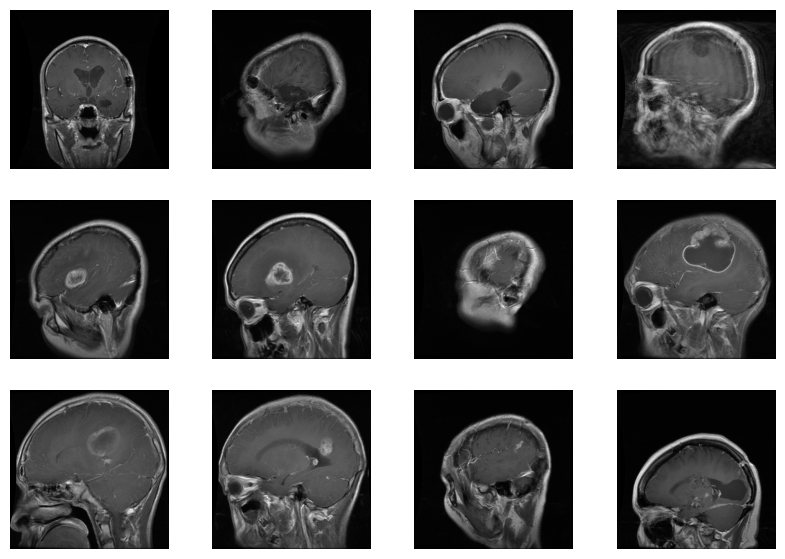

In [25]:
plt.figure(figsize=(10, 7))
for i in range(12):
    plt.subplot(3, 4, i+1) # i+1 because the index for matplotlib starts from 1, while i starts from 0
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

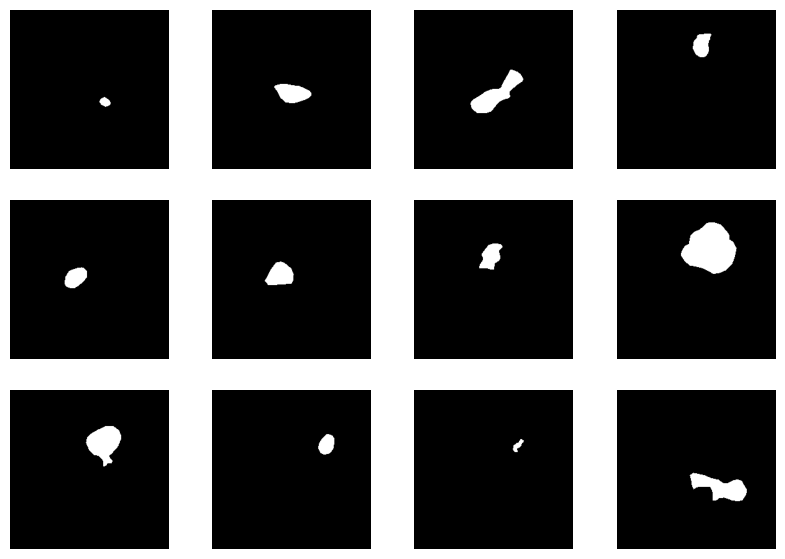

In [26]:
plt.figure(figsize=(10, 7))
for i in range(12):
    plt.subplot(3, 4, i+1) # i+1 because the index for matplotlib starts from 1, while i starts from 0
    plt.imshow(M[i], cmap="gray")
    plt.axis('off')
plt.show()

## Image Preprocessing

Split the data into training data, validation data, and testing data. In this case we will have a ratio of 70:15:15

In [13]:
stratify_labels = np.argmax(y, axis=1) # since the labels are already one-hot encoded
X_train, X_temp, y_train, y_temp, M_train, M_temp = train_test_split(X, y, M, test_size=0.3, random_state=42, stratify=stratify_labels)

stratify_temp = np.argmax(y_temp, axis=1)
X_val, X_test, y_val, y_test, M_val, M_test = train_test_split(X_temp, y_temp, M_temp, test_size=0.5, random_state=42, stratify=stratify_temp)

print(f'Training set: {X_train.shape}, {y_train.shape}, {M_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}, {M_val.shape}')
print(f'Testing set: {X_test.shape}, {y_test.shape}, {M_test.shape}')

Training set: (420, 256, 256), (420, 3), (420, 256, 256)
Validation set: (90, 256, 256), (90, 3), (90, 256, 256)
Testing set: (90, 256, 256), (90, 3), (90, 256, 256)


## Feature Extraction for Segmentation
Patch-based feature extraction

In [3]:
def glcm_features(patch, levels=16):
    # ensure integer gray levels required by graycomatrix
    if patch.dtype.kind == 'f':
        # assume floats are in [0,1]; scale to [0, levels-1]
        patch_scaled = np.clip(np.round(patch * (levels - 1)), 0, levels - 1).astype(np.uint8)
    else:
        # already integer type: clip to valid range
        patch_scaled = np.clip(patch, 0, levels - 1).astype(np.uint8)
    
    glcm = graycomatrix(
        patch_scaled,
        distances=[1],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=levels,
        symmetric=True,
        normed=True
    )
    
    eps = 1e-10
    # glcm shape: (levels, levels, n_distances, n_angles)
    p = glcm.copy()
    p = p / (p.sum(axis=(0,1), keepdims=True) + eps)  # per-slice normalization
    entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
    entropy_mean = entropies.mean()
    
    feats = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(), 
        'entropy': entropy_mean
    }
    return feats

In [7]:
def lbp_features(patch, P=16, R=2):
    # P = number of neighbors, R = radius
    lbp = local_binary_pattern(patch, P, R, method='uniform')
    
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, P+3),
                           range=(0, P+2))
    
    hist = hist.astype(float) / hist.sum() # normalize
    return hist

In [8]:
def gabor_features(patch, frequencies=[0.1, 0.2], thetas=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    feats = []
    
    for freq in frequencies:
        for theta in thetas:
            filt_real, filt_imag = gabor(patch, frequency=freq, theta=theta)
            feats.append(filt_real.mean())
            feats.append(filt_real.var())
    return feats

In [9]:
def spatial_features(x, y, img_shape):
    h, w = img_shape
    
    # coordinates (normalized)
    x_norm = x / w
    y_norm = y / h
    
    # Center coordinates
    x_c, y_c = w / 2, h / 2
    
    # Distance from center
    dist_center = np.sqrt((x - x_c)**2 + (y - y_c)**2) / np.sqrt((w/2)**2 + (h/2)**2)
    
    return [x_norm, y_norm, dist_center]

In [4]:
def extract_patch_features(img, x, y, patch_size=7): # patch-based feature extraction
    patch = img[x:x+patch_size, y:y+patch_size]
    
    # Intensity stats
    mean_intensity = patch.mean()
    var_intensity  = patch.var()
    
    # GLCM features
    glcm_feats = glcm_features(patch)
    
    # LBP features
    # lbp_hist = lbp_features(patch)
    
    # Gabor features
    # gabor_feats = gabor_features(patch)
    
    # Spatial features
    # spatial_feats = spatial_features(x, y, img.shape)
    
    # combine all features
    feature_vector = [
        mean_intensity,
        var_intensity,
        glcm_feats['contrast'],
        glcm_feats['correlation'],
        glcm_feats['energy'],
        glcm_feats['homogeneity'],
        glcm_feats['entropy']
    ] #+ lbp_hist.tolist() + gabor_feats + spatial_feats
    
    return feature_vector

In [11]:
def balanced_patch_sampling(img, mask, patch_size=7, ratio=1.0):
    h, w = img.shape
    half = patch_size // 2
    padded_img = np.pad(img, pad_width=half, mode='reflect')

    # Collect tumor and background coordinates
    tumor_coords = [(x,y) for x in range(h) for y in range(w) if mask[x,y] == 1]
    bg_coords    = [(x,y) for x in range(h) for y in range(w) if mask[x,y] == 0]

    # Sample background before feature extraction
    n_tumor = len(tumor_coords)
    n_bg    = int(n_tumor * ratio)
    bg_sample = np.random.choice(len(bg_coords), n_bg, replace=False)
    bg_coords = [bg_coords[i] for i in bg_sample]

    # Combine coords
    coords = tumor_coords + bg_coords

    # Extract features only for sampled coords
    X, y = [], []
    for (x,y_) in coords:
        feats = extract_patch_features(padded_img, x+half, y_+half, patch_size)
        X.append(feats)
        y.append(mask[x,y_])

    return np.array(X), np.array(y)


In [5]:
def build_dataset_from_image(img, mask, patch_size=7): # patch-based feature extraction for every pixel (expensive)
    h, w = img.shape
    half = patch_size // 2

    # Global padding to handle border pixels
    padded_img = np.pad(img, pad_width=half, mode='reflect')
    padded_mask = np.pad(mask, pad_width=half, mode='reflect')

    X = []
    y = []

    # Slide over every pixel in the original image's range
    for x in range(h):
        for y_ in range(w):
            # Extract features from patch centered at (x, y)
            features = extract_patch_features(padded_img, x + half, y_ + half, patch_size) # + half shift to account for padding
            label = padded_mask[x + half, y_ + half] # ground-truth label from mask

            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

### Dataset Reconstruction

In [14]:
results = Parallel(n_jobs=-1, backend="loky")( # Multi-processing for speed-up
    delayed(build_dataset_from_image)(img, mask) 
    for img, mask in tqdm(zip(X_train, M_train), total=len(X_train), desc="Building training dataset")
)

# Unpack results
X_all = [r[0] for r in results]
M_all = [r[1] for r in results]

# Final dataset
X_train = np.vstack(X_all)
M_train = np.hstack(M_all)

print(f'Final training dataset shape: {X_train.shape}, {M_train.shape}')

np.savez('train_varied_data.npz', X_train=X_train, M_train=M_train)

Building training dataset:   0%|          | 0/420 [00:00<?, ?it/s]

Building training dataset: 100%|██████████| 420/420 [23:29<00:00,  3.36s/it]


Final training dataset shape: (27525120, 7), (27525120,)


In [6]:
train = np.load('train_varied_data.npz')
X_train, M_train = train['X_train'], train['M_train']

In [15]:
results = Parallel(n_jobs=-1, backend="loky")( # Multi-processing for speed-up
    delayed(build_dataset_from_image)(img, mask) 
    for img, mask in tqdm(zip(X_val, M_val), total=len(X_val), desc="Building validation dataset")
)

# Unpack results
X_all = [r[0] for r in results]
M_all = [r[1] for r in results]

# Final dataset
X_val = np.vstack(X_all)
M_val = np.hstack(M_all)

print(f'Final validation dataset shape: {X_val.shape}, {M_val.shape}')

np.savez('val_varied_data.npz', X_val=X_val, M_val=M_val)

Building validation dataset: 100%|██████████| 90/90 [20:53<00:00, 13.92s/it]


Final validation dataset shape: (5898240, 7), (5898240,)


In [7]:
val = np.load('val_varied_data.npz')
X_val, M_val = val['X_val'], val['M_val']

In [19]:
results = Parallel(n_jobs=-1, backend="loky")( # Multi-processing for speed-up
    delayed(build_dataset_from_image)(img, mask) 
    for img, mask in tqdm(zip(X_test, M_test), total=len(X_test), desc="Building test dataset")
)

# Unpack results
X_all = [r[0] for r in results]
M_all = [r[1] for r in results]

# Final dataset
X_test = np.vstack(X_all)
M_test = np.hstack(M_all)

print(f'Final test dataset shape: {X_test.shape}, {M_test.shape}')

np.savez('test_varied_data.npz', X_test=X_test, M_test=M_test)

Building test dataset: 100%|██████████| 90/90 [15:43<00:00, 10.48s/it]


Final test dataset shape: (5898240, 7), (5898240,)


In [8]:
test = np.load('test_varied_data.npz')
X_test, M_test = test['X_test'], test['M_test']

# Training
## Training Preparation

In [16]:
rf_seg = RandomForestClassifier(
    n_estimators=125,
    max_depth=40,
    class_weight='balanced',
    min_samples_leaf=2,
    max_samples=0.5,
    random_state=42, 
    verbose=1, 
    n_jobs=-1
)

## Training Process

In [17]:
rf_seg.fit(X_train, M_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 31.6min finished


RandomForestClassifier(class_weight='balanced', max_depth=40, max_samples=0.5,
                       min_samples_leaf=2, n_estimators=125, n_jobs=-1,
                       random_state=42, verbose=1)

## Saving the Model

In [18]:
joblib.dump(rf_seg, 'models/rf_seg_simple.joblib', compress=3)

# Meta data
meta = {
    'patch_size': 7,
    'feature_dim': X_train.shape[1] if 'X_train' in globals() else None,
    'n_samples': int(X_train.shape[0]) if 'X_train' in globals() else None
}
joblib.dump(meta, 'models/rf_seg_meta.joblib')

['models/rf_seg_meta.joblib']

In [27]:
# Loading the model
rf_seg = joblib.load('models/rf_seg_simple.joblib')
meta_seg = joblib.load('models/rf_seg_meta.joblib')

# Training Results

In [28]:
M_val_pred = rf_seg.predict(X_val)

print("Pixel Accuracy:", accuracy_score(M_val, M_val_pred))
print("Dice/F1 Score:", f1_score(M_val, M_val_pred, average='weighted'))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.6s
[Parallel(n_jobs=16)]: Done 125 out of 125 | elapsed:   43.2s finished


Pixel Accuracy: 0.951404317220052
Dice/F1 Score: 0.9526744105722116


# Prediction

In [52]:
def segment_image(img, rf_model, patch_size=7): # function for segmenting a full image
    h, w = img.shape
    half = patch_size // 2
    padded_img = np.pad(img, pad_width=half, mode='reflect')

    features = []
    coords = []

    # Extract features for every pixel
    for x in tqdm(range(h), total=h, desc="Extracting features for segmentation"):
        for y in range(w):
            feats = extract_patch_features(padded_img, x+half, y+half, patch_size)
            features.append(feats)
            coords.append((x,y))

    print("Feature extraction completed. Predicting labels...")

    # Predict labels
    preds = rf_model.predict(features)
    kernel = np.ones((3, 3), np.uint8)
    opened_mask = cv2.morphologyEx(preds, cv2.MORPH_OPEN, kernel)
    closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel)

    # Reconstruct mask
    mask_pred = np.zeros((h,w), dtype=np.uint8)
    for (x,y), p in zip(coords, closed_mask):
        mask_pred[x,y] = p

    return mask_pred

In [68]:
def segment_image_proba(img, rf_model, patch_size=7): # function for segmenting a full image
    h, w = img.shape
    half = patch_size // 2
    padded_img = np.pad(img, pad_width=half, mode='reflect')

    features = []
    coords = []

    # Extract features for every pixel
    for x in tqdm(range(h), total=h, desc="Extracting features for segmentation"):
        for y in range(w):
            feats = extract_patch_features(padded_img, x+half, y+half, patch_size)
            features.append(feats)
            coords.append((x,y))

    print("Feature extraction completed. Predicting labels...")

    # Predict labels
    proba_map = rf_model.predict_proba(features)[:,1].reshape(h, w)
    smooth_map = cv2.GaussianBlur(proba_map, (5,5), 2) # smoothen probability map
    binary_mask = (smooth_map > 0.5).astype(np.uint8)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)
    if stats.shape[0] > 1:
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        final_mask = (labels == largest).astype(np.uint8)
    else:
        final_mask = np.zeros((h, w), dtype=np.uint8)

    # Reconstruct mask
    mask_pred = np.zeros((h,w), dtype=np.uint8)
    for (x,y), p in zip(coords, final_mask.flatten()):
        mask_pred[x,y] = p

    return mask_pred

Segmenting... (this can take a while)


Extracting features for segmentation:   0%|          | 0/256 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28568\412630381.py:23: RuntimeWarning: divide by zero encountered in log2
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28568\412630381.py:23: RuntimeWarning: invalid value encountered in multiply
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
Extracting features for segmentation: 100%|██████████| 256/256 [00:20<00:00, 12.43it/s]
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Feature extraction completed. Predicting labels...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 125 out of 125 | elapsed:   28.6s finished


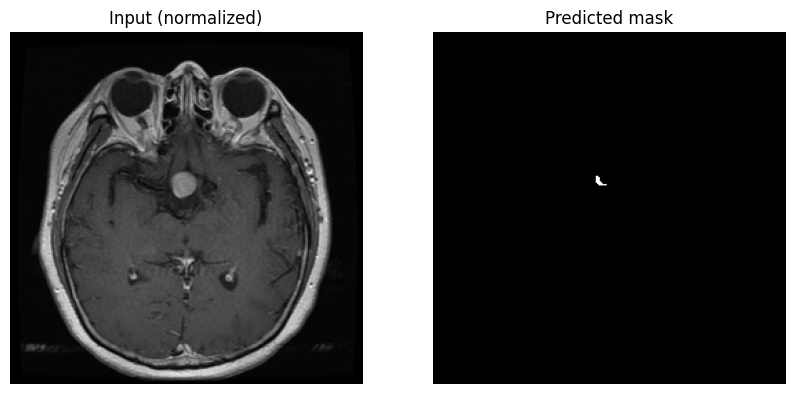

In [59]:
img_bgr = cv2.imread('data/Glioma/3058.png')
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, TARGET_SIZE)

# apply z-score normalization then min-max (same as dataset pipeline)
img_z = z_score_normalize(img_resized)
img_norm = cv2.normalize(img_z, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

print("Segmenting... (this can take a while)")

mask_pred = segment_image_proba(img_norm, rf_seg, patch_size=7)


# show input and predicted mask
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img_norm, cmap='gray')
ax[0].set_title('Input (normalized)'); ax[0].axis('off')
ax[1].imshow(mask_pred, cmap='gray')
ax[1].set_title('Predicted mask'); ax[1].axis('off')
plt.show()

Segmenting... (this can take a while)


Extracting features for segmentation:   0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28568\412630381.py:23: RuntimeWarning: divide by zero encountered in log2
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28568\412630381.py:23: RuntimeWarning: invalid value encountered in multiply
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
Extracting features for segmentation: 100%|██████████| 256/256 [00:29<00:00,  8.57it/s]
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Feature extraction completed. Predicting labels...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 125 out of 125 | elapsed:    1.7s finished


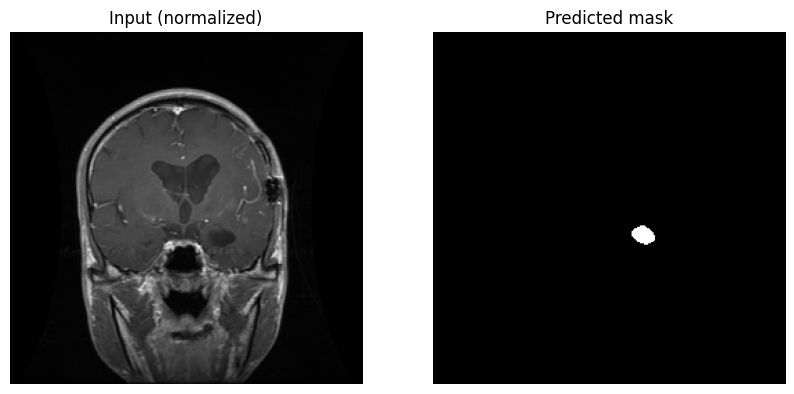

In [61]:
img_bgr = cv2.imread('data/Glioma/209.png')
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, TARGET_SIZE)

# apply z-score normalization then min-max (same as dataset pipeline)
img_z = z_score_normalize(img_resized)
img_norm = cv2.normalize(img_z, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

print("Segmenting... (this can take a while)")

mask_pred = segment_image_proba(img_norm, rf_seg, patch_size=7)


# show input and predicted mask
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img_norm, cmap='gray')
ax[0].set_title('Input (normalized)'); ax[0].axis('off')
ax[1].imshow(mask_pred, cmap='gray')
ax[1].set_title('Predicted mask'); ax[1].axis('off')
plt.show()

Segmenting... (this can take a while)


Extracting features for segmentation:   0%|          | 0/256 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28568\412630381.py:23: RuntimeWarning: divide by zero encountered in log2
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28568\412630381.py:23: RuntimeWarning: invalid value encountered in multiply
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
Extracting features for segmentation: 100%|██████████| 256/256 [00:32<00:00,  7.98it/s]
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Feature extraction completed. Predicting labels...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 125 out of 125 | elapsed:    7.3s finished


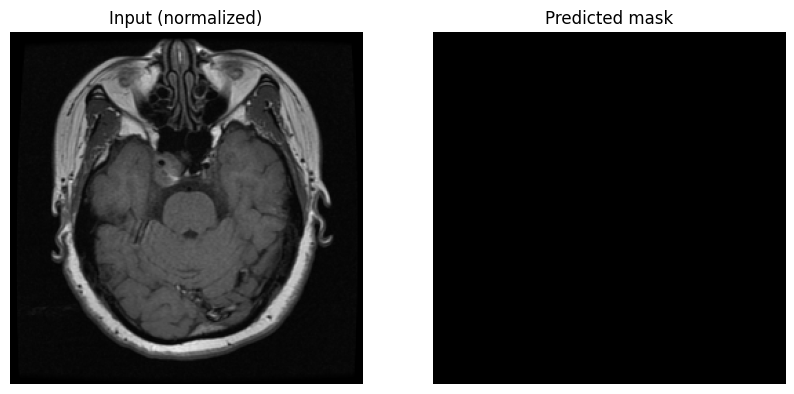

In [69]:
img_bgr = cv2.imread('data/Pituitary/1147.png')
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, TARGET_SIZE)

# apply z-score normalization then min-max (same as dataset pipeline)
img_z = z_score_normalize(img_resized)
img_norm = cv2.normalize(img_z, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

print("Segmenting... (this can take a while)")

mask_pred = segment_image_proba(img_norm, rf_seg, patch_size=7)


# show input and predicted mask
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img_norm, cmap='gray')
ax[0].set_title('Input (normalized)'); ax[0].axis('off')
ax[1].imshow(mask_pred, cmap='gray')
ax[1].set_title('Predicted mask'); ax[1].axis('off')
plt.show()

Segmenting... (this can take a while)


Extracting features for segmentation:   0%|          | 0/256 [00:00<?, ?it/s]C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28568\412630381.py:23: RuntimeWarning: divide by zero encountered in log2
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28568\412630381.py:23: RuntimeWarning: invalid value encountered in multiply
  entropies = -np.sum(np.where(p > 0, p * np.log2(p), 0.0), axis=(0,1))  # shape: (n_distances, n_angles)
Extracting features for segmentation: 100%|██████████| 256/256 [00:21<00:00, 11.65it/s]
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Feature extraction completed. Predicting labels...


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 125 out of 125 | elapsed:    7.8s finished


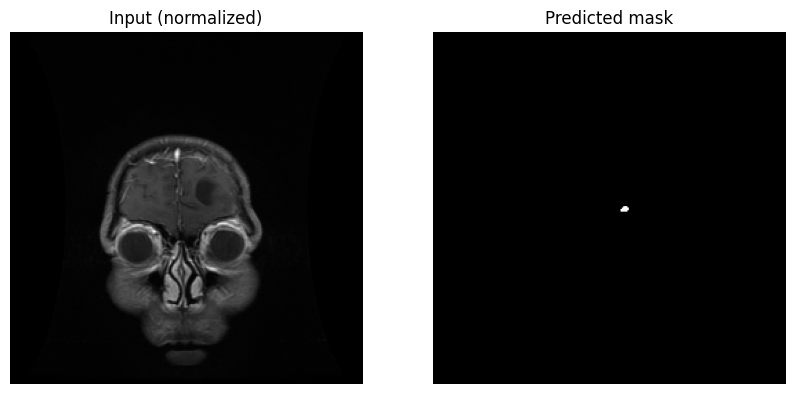

In [70]:
img_bgr = cv2.imread('data/Meningioma/201.png')
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, TARGET_SIZE)

# apply z-score normalization then min-max (same as dataset pipeline)
img_z = z_score_normalize(img_resized)
img_norm = cv2.normalize(img_z, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

print("Segmenting... (this can take a while)")

mask_pred = segment_image_proba(img_norm, rf_seg, patch_size=7)


# show input and predicted mask
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img_norm, cmap='gray')
ax[0].set_title('Input (normalized)'); ax[0].axis('off')
ax[1].imshow(mask_pred, cmap='gray')
ax[1].set_title('Predicted mask'); ax[1].axis('off')
plt.show()